# Commutative Test Demo

In this notebook, we will demonstrate how the commutative tests (as well as the glide commutative test) works, and provide code snippets to test the commutativity of demosaicing, JPEG compression, and their composition with horizontal reflection.

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from utils import mosaic, demosaic

TICK_SIZE = 20
TITLE_SIZE = 30
matplotlib.rc('xtick', labelsize=TICK_SIZE)
matplotlib.rc('ytick', labelsize=TICK_SIZE)
matplotlib.rc('axes', labelsize=TITLE_SIZE)

### Below are helper functions we will use for the commutative tests. These are:
- rand_rgb_image : Return a randomly generated image (in numpy array)
- flip_image : Flip an image horizontally.
- jpeg_image : JPEG compress the image into memory then read it back to numpy array.
- debayer_image : Use bayer pattern to mosaic the image to greyscale, then demosaic it back to an RGB image.

In [2]:
def rand_rgb_image(x, y, image_pattern):
    """
    Return image has RGB channels.
    """ 
    if image_pattern == 'gaussian_rgb':
        red = np.random.normal(0.6, 0.3, (y, x, 1))
        blue = np.random.normal(0.5, 0.25, (y, x, 1))
        green = np.random.normal(0.9, 0.4, (y, x, 1))
        image = np.concatenate((red, green, blue), axis=2)
        image[image > 1.0] = 1.0
        image[image < 0.0] = 0.0
        image = (255 * image).astype('uint8')
    elif image_pattern == 'uniform':
        image = np.random.uniform(size=(y, x, 3))
        image = (255 * image).astype('uint8')
    else:
        raise NotImplementedError()
    return image

def flip_image(img):
    return img[:, ::-1, :]

def jpeg_image(img, encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 25]):
    processing_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    _, processing_img = cv2.imencode('.jpg', processing_img, encode_param)
    processing_img = cv2.imdecode(processing_img, 1)
    return cv2.cvtColor(processing_img, cv2.COLOR_BGR2RGB)

def debayer_image(img, bayer_pattern='RGGB', demosaic_algo='Malvar2004'):
    image_demosaiced = demosaic(
                           mosaic(img, pattern=bayer_pattern),
                           pattern=bayer_pattern,
                           algo=demosaic_algo
                       ).astype('uint8')
    return image_demosaiced
    
def comm_test(image, image_pattern="gaussian_rgb", image_type="original"):
    flipped_image = flip_image(image)
    if image_type == 'original':
        processed_image_flipped = flip_image(image)/ 255.
        processed_flipped_image = flipped_image/ 255.
    elif image_type == 'jpeg':
        processed_image_flipped = flip_image(jpeg_image(image))/ 255.
        processed_flipped_image = jpeg_image(flipped_image)/ 255.
    elif image_type == 'demosaic':
        processed_image_flipped = flip_image(debayer_image(image))/ 255.
        processed_flipped_image = debayer_image(flipped_image)/ 255.
    elif image_type == 'both':
        processed_image_flipped = flip_image(jpeg_image(debayer_image(image)))/ 255.
        processed_flipped_image = jpeg_image(debayer_image(flipped_image))/ 255.
    
    return np.abs(processed_image_flipped - processed_flipped_image).mean()

### Run below cell for an example of a randomly generated image and its processed versions.

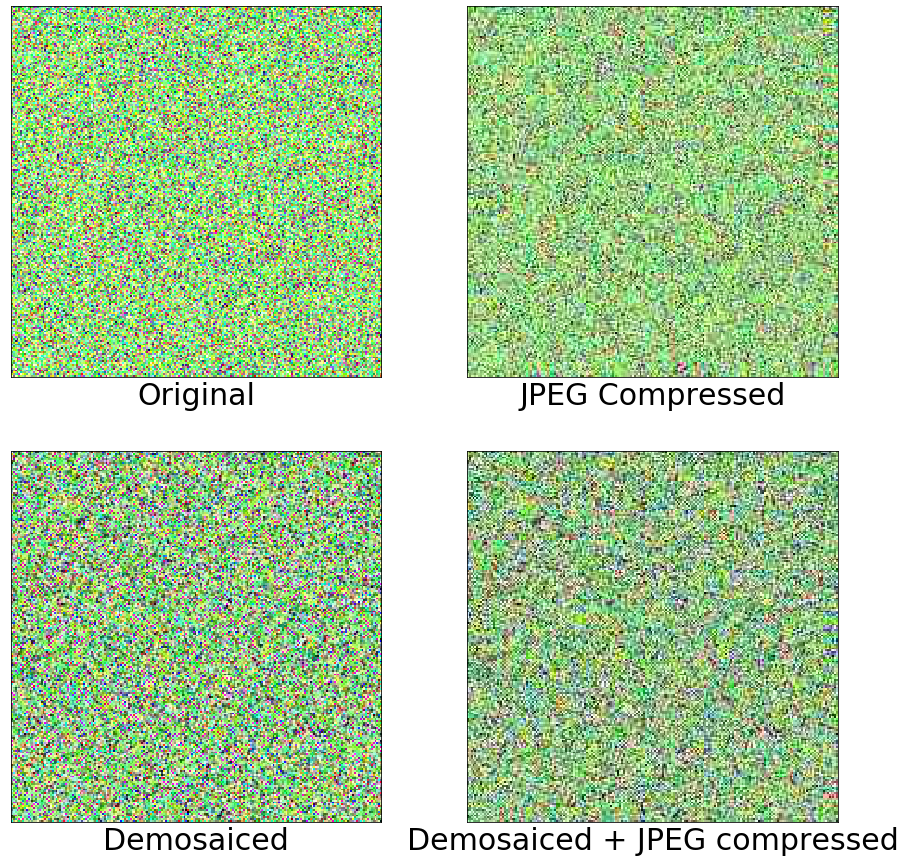

In [3]:
# Please run this block of code
width = 200
height = 200

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.setp(axs, xticks=[], yticks=[])
plt.setp(axs[0,0], xlabel="Original")
plt.setp(axs[0,1], xlabel="JPEG Compressed")
plt.setp(axs[1,0], xlabel="Demosaiced")
plt.setp(axs[1,1], xlabel="Demosaiced + JPEG compressed")

rand_image = rand_rgb_image(width, height, "gaussian_rgb")  
# rand_image = rand_rgb_image(width, height, "uniform")
axs[0,0].imshow(rand_image)
axs[0,1].imshow(jpeg_image(rand_image))
axs[1,0].imshow(debayer_image(rand_image))
axs[1,1].imshow(jpeg_image(debayer_image(rand_image)))


### Now we perform commutative tests (without gliding) over different dimensions of images.

In [7]:
def get_residual(all_x, all_y, op):
    z = np.zeros((len(all_y), len(all_x)))
    for ix, x in enumerate(all_x):
        for iy, y in enumerate(all_y):
            rand_image = rand_rgb_image(x, y, "gaussian_rgb")  
            residual = comm_test(rand_image, image_type=op)
            z[iy][ix] = residual
    return z

In [14]:
start = 15
end = 68
x = np.arange(start, end)

z_d = get_residual(x, x, "demosaic")
z_j = get_residual(x, x, "jpeg")
z_b = get_residual(x, x, "both")

z_max = max(z_d.max(), z_j.max(), z_b.max())

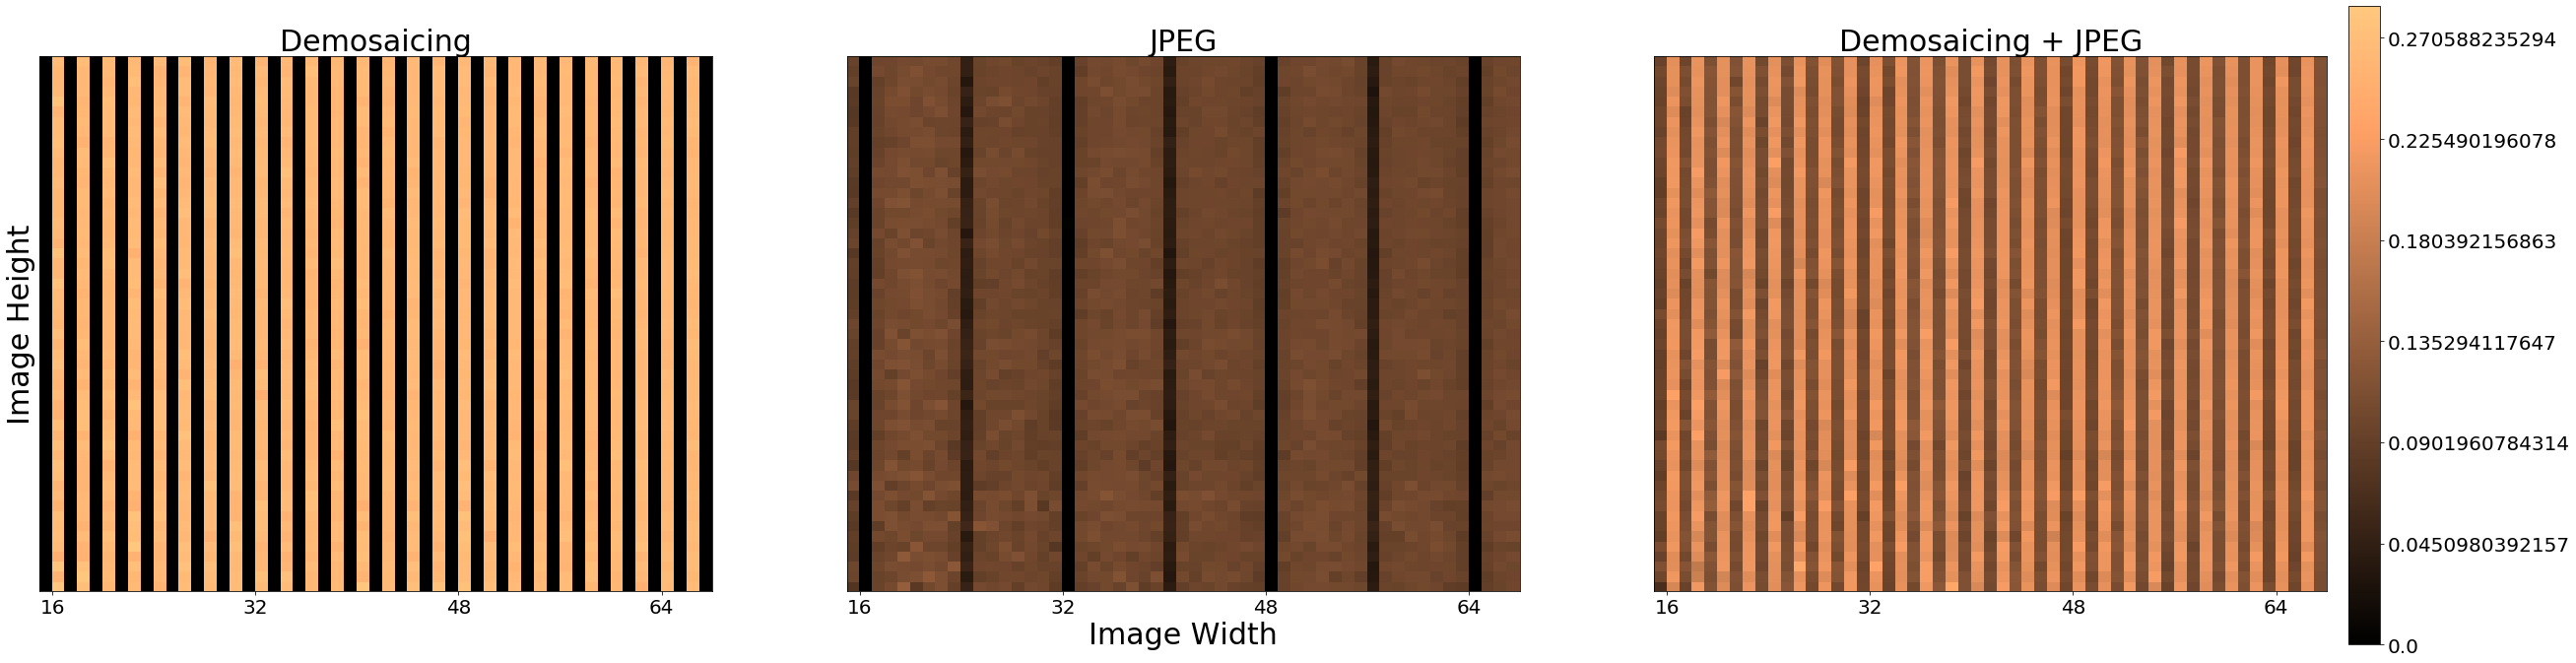

In [15]:
# Commutative Test plots
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

xticks_pos=[16, 32, 48, 64]
plt.setp(axs, xticks=[t - start for t in xticks_pos], xticklabels=xticks_pos, yticks=[])
plt.setp(axs[0], ylabel="Image Height")
plt.setp(axs[1], xlabel="Image Width")

axs[0].pcolor(z_d, cmap='copper', vmin=0, vmax=z_max)
axs[0].set_title('Demosaicing', fontsize=TITLE_SIZE)


axs[1].pcolor(z_j, cmap='copper', vmin=0, vmax=z_max)
axs[1].set_title('JPEG', fontsize=TITLE_SIZE)


c = axs[2].pcolor(z_b, cmap='copper', vmin=0, vmax=z_max)
axs[2].set_title('Demosaicing + JPEG', fontsize=TITLE_SIZE)


fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([1.21, 0.05, 0.015, 0.9])
cbar = fig.colorbar(c, cax=cbar_ax)
cbar.ax.set_yticklabels(np.linspace(0, z_max, num=8))
plt.tick_params(labelsize=TICK_SIZE)

plt.show()

### For glide commutative tests, we will utilize the below helper functions:
- pad_image: Pad an numpy array
- unpad_image: Translate the image by phase offset, then undone the padding.
- shift_image: Shift the image (it should be already padded) by phase offset.

In [16]:
# Helper for glide commu test
PAD_WIDTH = 38
def pad_image(img, pad_width=PAD_WIDTH):
    return np.pad(img, [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode='constant')

def unpad_image(img, shift_phase, pad_width=PAD_WIDTH):
    img_y = img.shape[0] - 2 * pad_width
    img_x = img.shape[1] - 2 * pad_width
    return img[pad_width:pad_width+img_y, pad_width+shift_phase:pad_width+shift_phase+img_x, :]

def shift_image(img, shift_phase):
    return np.roll(img, shift_phase, axis=1)

### Now we perform glide commutative tests over different phase offsets.

In [17]:
def glide_comm_test(image, phi_1, phi_2, image_type='original', pad_width=PAD_WIDTH):
    padded = pad_image(image)
    img_y = image.shape[0]
    img_x = image.shape[1]
    
    if image_type == 'original':
        J = lambda x : x
    elif image_type == 'jpeg':
        J = jpeg_image
    elif image_type == 'demosaic':
        J = debayer_image
    elif image_type == 'both':
        J = lambda x: jpeg_image(debayer_image(x))
    
    
    J_T_phi_1_image = J(
                          flip_image(
                              shift_image(padded,phi_1)
                          )
                      )/ 255.
    J_T_phi_1_image = unpad_image(J_T_phi_1_image, -phi_1)
    
    T_J_phi_2_image = flip_image(
                          J(
                              shift_image(padded,phi_2)
                          )
                      )/ 255.
    T_J_phi_2_image = unpad_image(T_J_phi_2_image, -phi_2)
    
    return np.abs(J_T_phi_1_image - T_J_phi_2_image).mean()

def get_glide_residual(all_phi_1, all_phi_2, op, width=35, height=33):
    rand_image = rand_rgb_image(width, height, "gaussian_rgb")
    z = np.zeros((len(all_phi_1), len(all_phi_2)))
    for iphi_1, phi_1 in enumerate(all_phi_1):
        for iphi_2, phi_2 in enumerate(all_phi_2): 
            residual = glide_comm_test(rand_image, phi_1, phi_2, image_type=op)
            z[iphi_1][iphi_2] = residual
    return z

In [18]:
x= np.arange(0, 20)

gz_d = get_glide_residual(x, x, "demosaic")
gz_j = get_glide_residual(x, x, "jpeg")
gz_b = get_glide_residual(x, x, "both")
gz_max = max(gz_d.max(), gz_j.max(), gz_b.max())


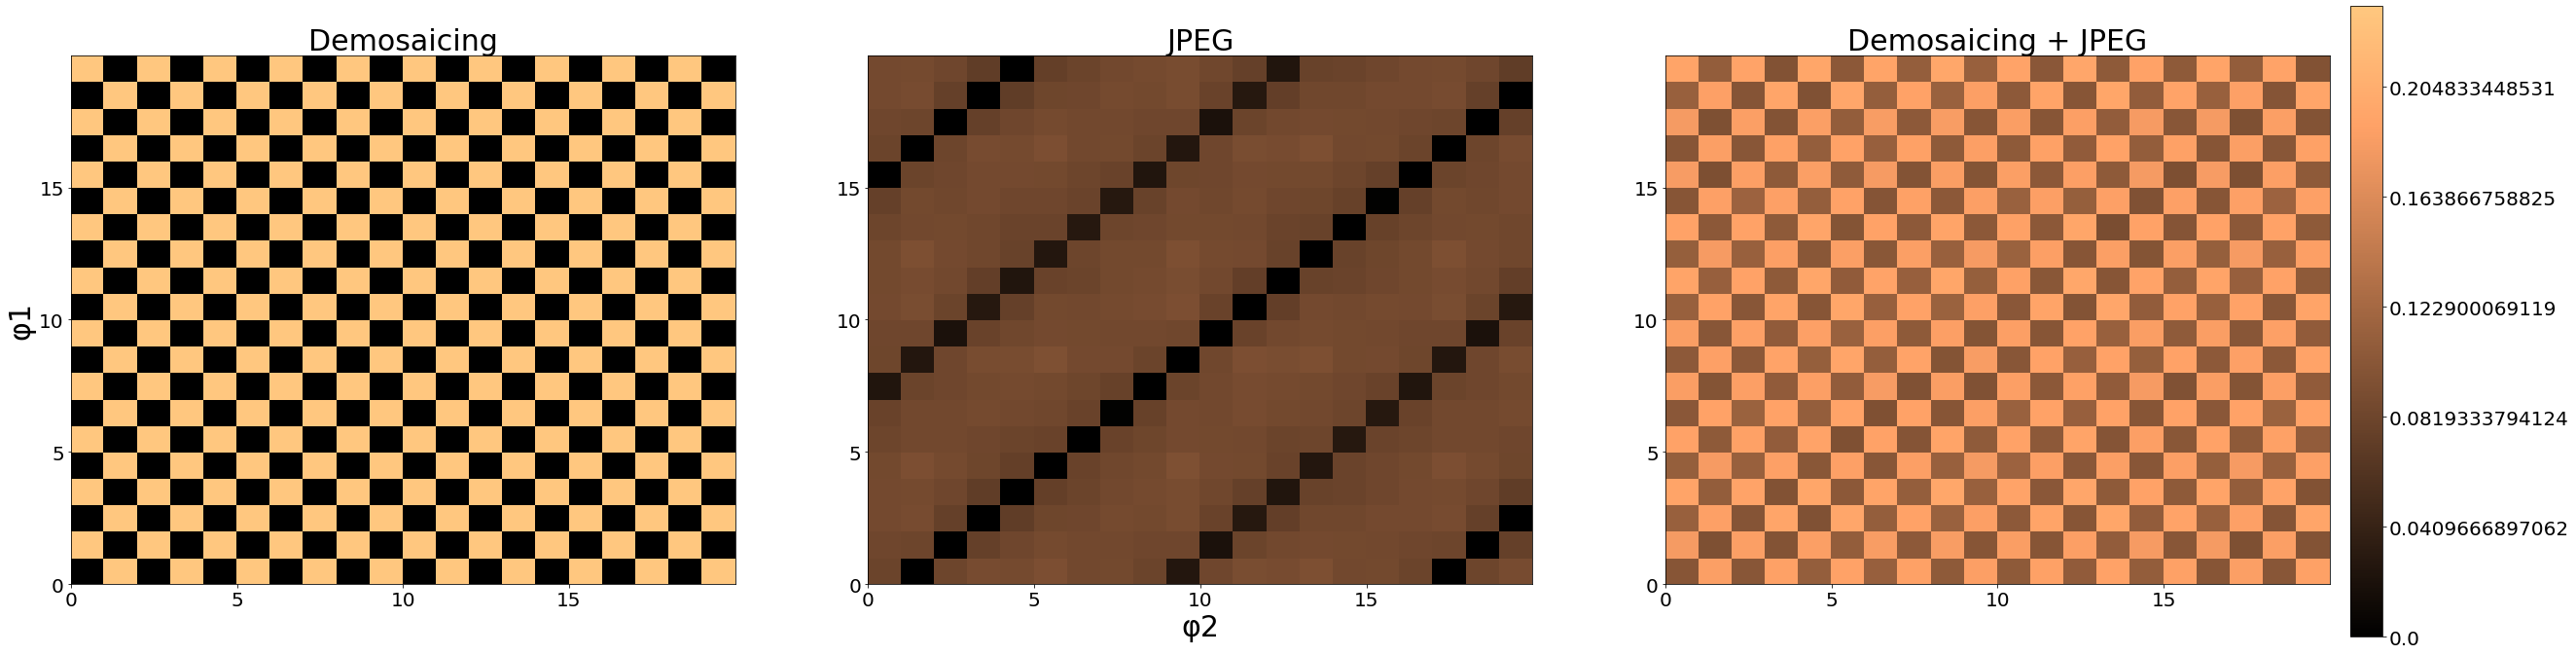

In [19]:
# Glide Commutative Test plots
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.setp(axs, xticks=[0, 5, 10, 15], yticks=[0, 5, 10, 15])
plt.setp(axs[0], ylabel="φ1")
plt.setp(axs[1], xlabel="φ2")

axs[0].pcolor(gz_d, cmap='copper', vmin=0, vmax=gz_max)
axs[0].set_title('Demosaicing', fontsize=TITLE_SIZE)


axs[1].pcolor(gz_j, cmap='copper', vmin=0, vmax=gz_max)
axs[1].set_title('JPEG', fontsize=TITLE_SIZE)


c = axs[2].pcolor(gz_b, cmap='copper', vmin=0, vmax=gz_max)
axs[2].set_title('Demosaicing + JPEG', fontsize=TITLE_SIZE)


fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([1.21, 0.05, 0.015, 0.9])
cbar = fig.colorbar(c, cax=cbar_ax)
cbar.ax.set_yticklabels(np.linspace(0, gz_max, num=8))
plt.tick_params(labelsize=TICK_SIZE)

plt.show()